# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    485      0 --:--:-- --:--:-- --:--:--   484
100 1546k  100 1546k    0     0  1264k      0  0:00:01  0:00:01 --:--:--  100M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    636      0 --:--:-- --:--:-- --:--:--   636
100  385k  100  385k    0     0   365k      0  0:00:01  0:00:01 --:--:--  125M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    866      0 --:--:-- --:--:-- --:--:--   866
100  230k  100  230k    0     0   281k      0 --:--:-- --:--:-- --:--:--  112M


In [23]:
!pip3 install implicit --upgrade

Requirement already up-to-date: implicit in /usr/local/lib/python3.6/dist-packages (0.4.4)


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** Modela el problema como matrices, teniendo por un lado una matriz de interaccines y por otro un vector de usuario e item. Así, el entrenamiento del modelo se basa en que los vectores de usuario y de item se van actualizando alternamente, hasta llegar a que la matriz generada por el producto punto de ambos vectores sea lo más parecida posible a la matríz original.

Una vez entrenado el modelo, dado que llegams auna matriz similar a la original, los resultados deberían acercarse a la predicción deseada.

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                       Contact (1997)
273                                          Heat (1995)
754                                    Red Corner (1997)
257                                  Men in Black (1997)
256    When the Cats Away (Chacun cherche son chat) (...
292                                      Rosewood (1997)
299                                       Hoodlum (1997)
136                  Mr. Smith Goes to Washington (1939)
125                                    Phenomenon (1996)
248                           Grosse Pointe Blank (1997)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.0598551127795653
ndcg: 0.34150076569678406


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [25]:
import matplotlib.pyplot as plt

Variación de `factors`:


val:  [1, 5, 10, 50, 100, 200, 300]
map:  [0.050940589747367995, 0.057178368257013425, 0.05175907472318907, 0.06973851564714487, 0.06161192347564416, 0.04909986343294494, 0.03830306771445922]


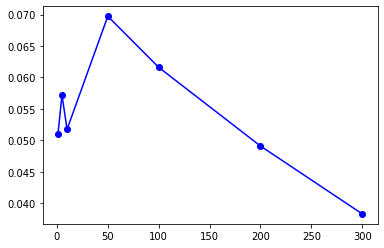

val:  [1, 5, 10, 50, 100, 200, 300]
ndcg: [0.30627871362940273, 0.32618683001531396, 0.3215926493108729, 0.33996937212863704, 0.327718223583461, 0.28177641653905056, 0.27105666156202146]


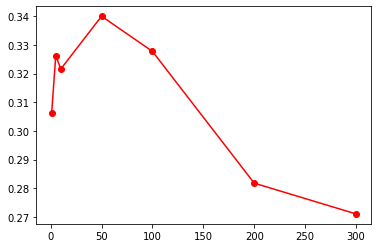

In [28]:
values = [1, 5, 10, 50, 100, 200, 300] # definir distintos numeros
mapr_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for v in values:
    model_als = implicit.als.AlternatingLeastSquares(factors=v, iterations=10, use_gpu=False)
    model_als.fit(matrix)
    mapr, ndcg = evaluate_model(model_als, n=10)
    mapr_values.append(mapr)
    ndcg_values.append(ndcg)

print('val: ', values)
print('map: ', mapr_values)
plt.plot(values, mapr_values, 'bo-')
plt.show()

print('val: ', values)
print('ndcg:', ndcg_values)
plt.plot(values, ndcg_values, 'ro-')
plt.show()

Variación de `iterations`:


val:  [5, 10, 50, 100, 200]
map:  [0.05786354777185968, 0.05982472696929893, 0.0622209741527367, 0.06342829104761306, 0.06187196553697257]


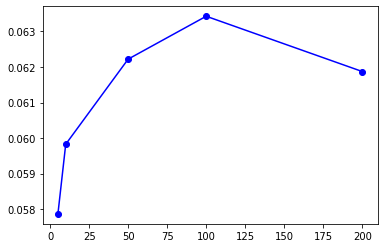

val:  [5, 10, 50, 100, 200]
ndcg: [0.327718223583461, 0.3460949464012251, 0.33690658499234305, 0.34150076569678406, 0.332312404287902]


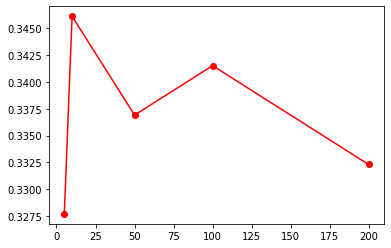

In [27]:
values = [5, 10, 50, 100, 200] # definir distintos numeros
mapr_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for v in values:
    model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=v, use_gpu=False)
    model_als.fit(matrix)
    mapr, ndcg = evaluate_model(model_als, n=10)
    mapr_values.append(mapr)
    ndcg_values.append(ndcg)

print('val: ', values)
print('map: ', mapr_values)
plt.plot(values, mapr_values, 'bo-')
plt.show()

print('val: ', values)
print('ndcg:', ndcg_values)
plt.plot(values, ndcg_values, 'ro-')
plt.show()

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

**Respuesta:** Parte de la suposición de que los items con los que interactuó el usuario recibieron _feedback_ "positivo" y los que no han tenido interacciones cuentan como _feedback_ "negativo".

Con esta idea en mente, se generan variadas tripletas con 1 usuario, 1 item con el que interactuó y 1 item con el que no interactuó. Luego, si ponemos esto en una factorización matricial, en este modelo las tripletas serían los vectores a usar. Por lo que, en la práctica, cada tripleta nos estaría entregando un poco de información nueva.

In [19]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [29]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                               Men in Black (1997)
285                             Secrets & Lies (1996)
299                                    Hoodlum (1997)
244                     Smilla's Sense of Snow (1997)
327                                   Cop Land (1997)
332                             Kiss the Girls (1997)
300                              Air Force One (1997)
331                                  Edge, The (1997)
312    Midnight in the Garden of Good and Evil (1997)
746                                Real Genius (1985)
Name: title, dtype: object

In [21]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171              Delicatessen (1991)
209        This Is Spinal Tap (1984)
203                Unforgiven (1992)
68                  Crow, The (1994)
21     Muppet Treasure Island (1996)
194                Sting, The (1973)
95                    Aladdin (1992)
175                    Brazil (1985)
78                 Free Willy (1993)
201              Evil Dead II (1987)
Name: title, dtype: object

In [22]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.051109810971137426
ndcg: 0.3445635528330781


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

Variación de `factors`:


val:  [1, 5, 10, 50, 100, 200, 400, 500, 600, 1000]
map:  [0.06515891439953504, 0.052807464779844514, 0.051238812521418035, 0.04940382589452234, 0.05206068752346057, 0.05202366480743625, 0.053896619233112626, 0.05095117906559714, 0.050955996488852615, 0.05880116832257471]


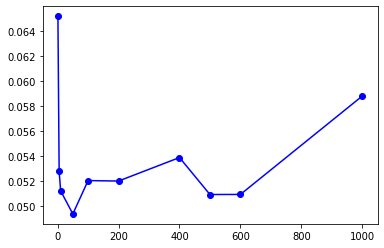

val:  [1, 5, 10, 50, 100, 200, 400, 500, 600, 1000]
ndcg: [0.3460949464012251, 0.333843797856049, 0.3231240428790199, 0.35068912710566613, 0.33690658499234305, 0.33996937212863704, 0.37366003062787134, 0.3445635528330781, 0.3430321592649311, 0.36447166921898927]


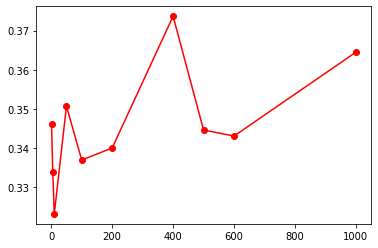

In [33]:
values = [1, 5, 10, 50, 100, 200, 400, 500, 600, 1000] # definir distintos numeros
mapr_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for v in values:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=v, iterations=40, use_gpu=False)
    model_bpr.fit(matrix)
    mapr, ndcg = evaluate_model(model_bpr, n=10)
    mapr_values.append(mapr)
    ndcg_values.append(ndcg)

print('val: ', values)
print('map: ', mapr_values)
plt.plot(values, mapr_values, 'bo-')
plt.show()

print('val: ', values)
print('ndcg:', ndcg_values)
plt.plot(values, ndcg_values, 'ro-')
plt.show()

Variación de `iterations`:


val:  [1, 5, 10, 20, 40, 80, 160]
map:  [0.056904878230269344, 0.04867687718521457, 0.05149677573818726, 0.060143834408746655, 0.05074081934284023, 0.03861743137789356, 0.030336787827255223]


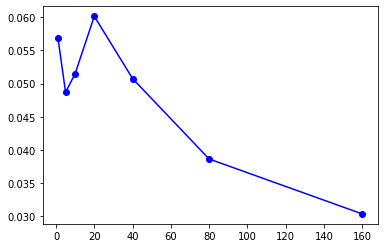

val:  [1, 5, 10, 20, 40, 80, 160]
ndcg: [0.3445635528330781, 0.3169984686064318, 0.31852986217457885, 0.333843797856049, 0.3552833078101072, 0.2725880551301684, 0.25114854517611024]


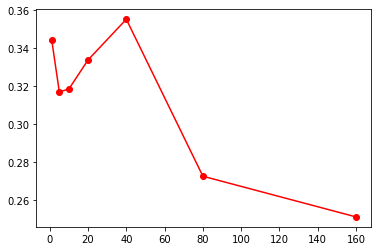

In [32]:
values = [1, 5, 10, 20, 40, 80, 160] # definir distintos numeros
mapr_values = [] # para almacenar resultados de MAP
ndcg_values = [] # para almacenar valores de NDCG

for v in values:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=v, use_gpu=False)
    model_bpr.fit(matrix)
    mapr, ndcg = evaluate_model(model_bpr, n=10)
    mapr_values.append(mapr)
    ndcg_values.append(ndcg)

print('val: ', values)
print('map: ', mapr_values)
plt.plot(values, mapr_values, 'bo-')
plt.show()

print('val: ', values)
print('ndcg:', ndcg_values)
plt.plot(values, ndcg_values, 'ro-')
plt.show()